In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib inline

In [2]:
df=pd.read_csv('flight_delays_train.csv')
df.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


Let's extract the month, date and day of week from their respective columns.

In [3]:
df['Month']=df['Month'].apply(lambda Month: Month.split('-')[1])
df['DayofMonth']=df['DayofMonth'].apply(lambda DayofMonth: DayofMonth.split('-')[1])
df['DayOfWeek']=df['DayOfWeek'].apply(lambda DayOfWeek: DayOfWeek.split('-')[1])

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Month              100000 non-null  object
 1   DayofMonth         100000 non-null  object
 2   DayOfWeek          100000 non-null  object
 3   DepTime            100000 non-null  int64 
 4   UniqueCarrier      100000 non-null  object
 5   Origin             100000 non-null  object
 6   Dest               100000 non-null  object
 7   Distance           100000 non-null  int64 
 8   dep_delayed_15min  100000 non-null  object
dtypes: int64(2), object(7)
memory usage: 6.9+ MB


In [5]:
df['dep_delayed_15min'].value_counts(normalize=True)

N    0.80956
Y    0.19044
Name: dep_delayed_15min, dtype: float64

We are dealing with an unbalanced dataset, only 19% of the flights belong to the delayed category.

Let's now split the DepTime which is in 24 hr format into separate hours and minutes. For this we will be slicing the values to get the hours and minutes and then converting them into our own standardised feature ie. minutes after midnight.

In [6]:
df.DepTime=df.DepTime.astype(str)
df['Hours']=df.DepTime.apply(lambda x: x[:-2])
df['Minutes']=df.DepTime.apply(lambda x: x[-2:])

In [7]:
df.Hours.nunique()

26

In [8]:
df.Hours.value_counts()

8     6620
17    6562
9     6409
10    6363
12    6363
11    6340
7     6329
6     6315
13    6178
15    6170
16    6112
18    6110
14    6006
19    5500
20    4430
21    3505
22    1787
5     1636
23     779
       308
1       76
4       38
2       27
24      23
3        8
25       6
Name: Hours, dtype: int64

In [9]:
df[df.Hours=='25']

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min,Hours,Minutes
20766,5,31,2,2534,EV,ATL,HSV,151,Y,25,34
27391,3,23,4,2505,EV,ATL,AGS,143,Y,25,05
47218,1,2,1,2500,EV,ATL,ILM,377,Y,25,00
48180,2,27,7,2514,EV,ATL,CAE,191,Y,25,14
77163,2,27,7,2522,EV,CVG,SHV,686,Y,25,22
98924,7,5,2,2530,EV,ATL,GNV,300,Y,25,30


We see that 308 values have no entry as Hour, we will fill these with 0, however 6 values have 25 as the hour which doesn't make sense. Since our dataset comprises of 100000 values we will just go ahead and exclude these 6 values from our training set.

In [10]:
df.Hours=df.Hours.replace('','0')

In [11]:
df=df[df.Hours!='25']

In [12]:
df.Minutes.nunique()

69

In [13]:
df.Minutes.unique()

array(['34', '48', '22', '15', '28', '18', '54', '35', '29', '36', '05',
       '24', '37', '47', '42', '01', '20', '04', '21', '19', '17', '50',
       '13', '10', '27', '30', '53', '03', '46', '07', '44', '23', '00',
       '09', '25', '16', '12', '55', '51', '31', '58', '45', '32', '57',
       '56', '14', '52', '11', '26', '06', '41', '43', '40', '33', '02',
       '38', '08', '59', '49', '39', '5', '2', '7', '3', '4', '8', '6',
       '1', '9'], dtype=object)

Some of the digits have been repeated like 9 and 09, however when we will convert this column from string to integer it will automatically adjust for all these values, so let's just do that right away for the Hours and Minutes column.

In [14]:
df.Minutes=df.Minutes.astype(int)
df.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min,Hours,Minutes
0,8,21,7,1934,AA,ATL,DFW,732,N,19,34
1,4,20,3,1548,US,PIT,MCO,834,N,15,48
2,9,2,5,1422,XE,RDU,CLE,416,N,14,22
3,11,25,6,1015,OO,DEN,MEM,872,N,10,15
4,10,7,6,1828,WN,MDW,OMA,423,Y,18,28


## EDA
Now let's look at the data and analyse what relationships the features have with the target variable.

In [15]:
df.shape

(99994, 11)

In [16]:
df.nunique()

Month                  12
DayofMonth             31
DayOfWeek               7
DepTime              1294
UniqueCarrier          22
Origin                289
Dest                  289
Distance             1310
dep_delayed_15min       2
Hours                  25
Minutes                60
dtype: int64

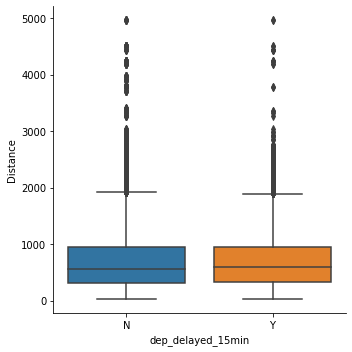

In [17]:
sns.catplot(y='Distance',x='dep_delayed_15min',data=df,kind='box')

We see that the flight delays are almost equally distributed with distance. We can also see some outliers here. Let's see the realtionship of the label with month and carrier columns too.

<AxesSubplot:xlabel='UniqueCarrier', ylabel='count'>

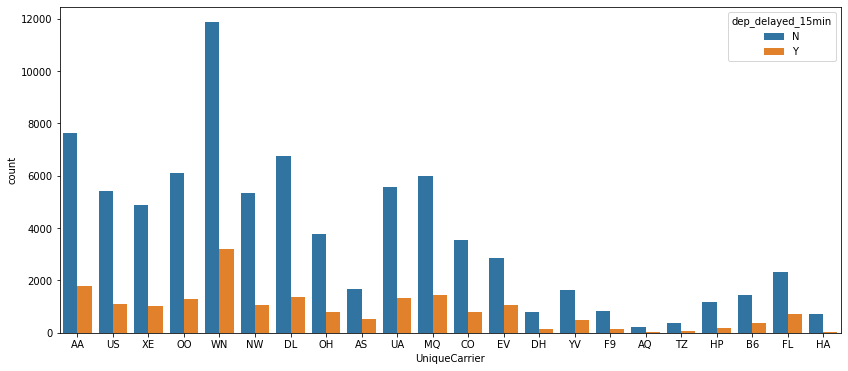

In [18]:
plt.figure(figsize=(14,6))
sns.countplot(x='UniqueCarrier',data=df,hue='dep_delayed_15min')

We see that the carrier WN has the maximum number of flight delays, however this maybe just because of the fact that WN has the maximum number of flights in the dataset.

<AxesSubplot:xlabel='count', ylabel='Month'>

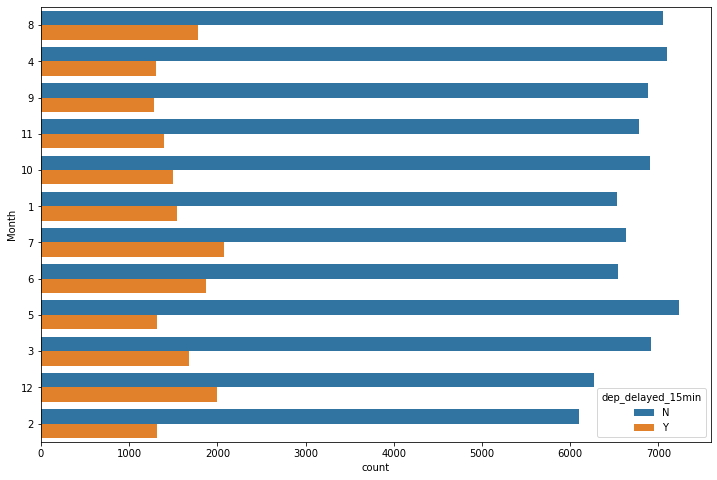

In [19]:
plt.figure(figsize=(12,8))
sns.countplot(y='Month',data=df,hue='dep_delayed_15min')

There is almost an even distribution of flights delays among the months, however we can see that month 7 ie, July has the highest number of delays although only marginally higher. Maybe the weather had something to do with it?

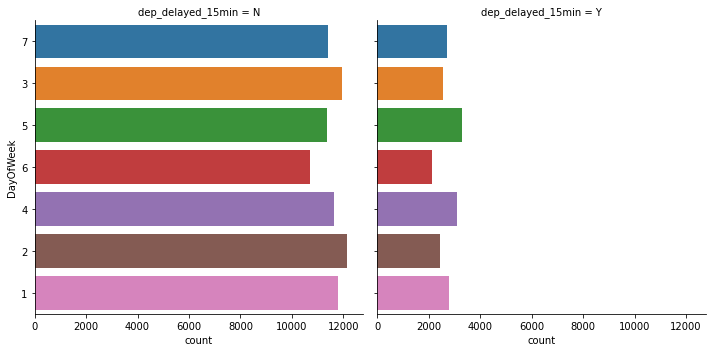

In [20]:
sns.catplot(y="DayOfWeek",col='dep_delayed_15min',kind='count',data=df)

Again the flights delays are almost evenly distributed among the days with Saturday having the least delays in the week and Friday having the highest. This is expected as many people choose to go away for the weekend and travel on Fridays.
Let's see what the relationship the hour variable has with our target.

<AxesSubplot:xlabel='Hours', ylabel='count'>

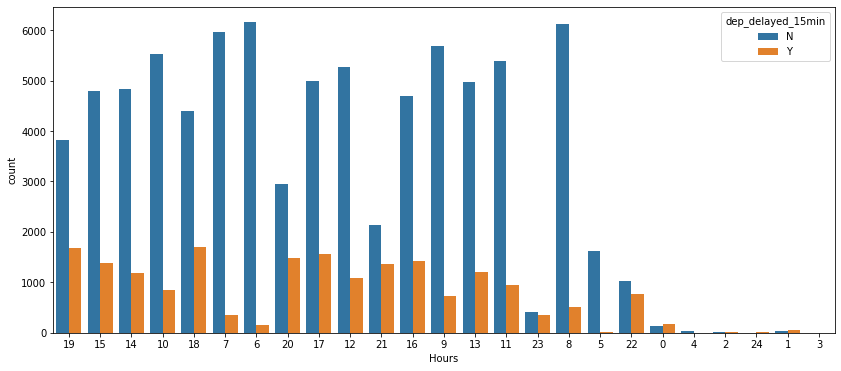

In [21]:
plt.figure(figsize=(14,6))
sns.countplot(x='Hours',data=df,hue='dep_delayed_15min')

We see that the hour is a very strong feature so we will use it in our model, however the minutes has little relevance so we will go ahead and drop the Minutes column.

<AxesSubplot:xlabel='DayofMonth', ylabel='count'>

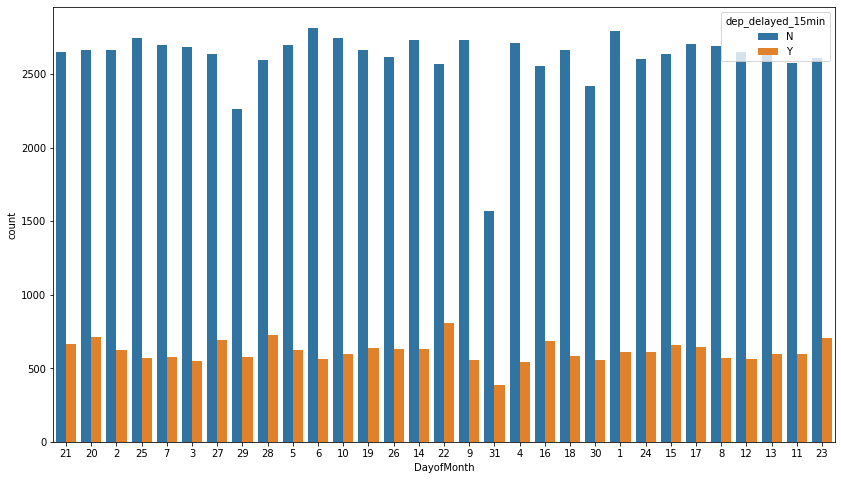

In [22]:
plt.figure(figsize=(14,8))
dayorder=list(range(1,32))
sns.countplot(x="DayofMonth",data=df,hue='dep_delayed_15min')

Again the flights are evenly distributed throughout the month, with the last day of month having the least number of flights.

# Preprocessing

We will one hot encode the DayOfWeek column since it can take only 7 values.

In [23]:
df=df.drop(['DepTime','Minutes'],axis=1)
df.head()

,Month,DayofMonth,DayOfWeek,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min,Hours
0,8,21,7,AA,ATL,DFW,732,N,19
1,4,20,3,US,PIT,MCO,834,N,15
2,9,2,5,XE,RDU,CLE,416,N,14
3,11,25,6,OO,DEN,MEM,872,N,10
4,10,7,6,WN,MDW,OMA,423,Y,18


In [24]:
df= pd.get_dummies(df,columns=['DayOfWeek'])

In [25]:
#Encode label column
df['Target'] = df['dep_delayed_15min'].map({'N':0,'Y':1})
df=df.drop('dep_delayed_15min',axis=1)

## Split data into train and test sets

In [26]:
from sklearn.model_selection import train_test_split

In [27]:
X=df.drop('Target',axis=1)
y=df.Target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42,stratify=y)

In [28]:
y_train.value_counts(normalize=True)

0    0.809613
1    0.190387
Name: Target, dtype: float64

In [29]:
y_test.value_counts(normalize=True)

0    0.80959
1    0.19041
Name: Target, dtype: float64

In [30]:
X_test.head()

,Month,DayofMonth,UniqueCarrier,Origin,Dest,Distance,Hours,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,DayOfWeek_7
6735,2,28,HP,PHX,LAX,370,8,1,0,0,0,0,0,0
23941,3,14,DL,ATL,JAX,270,13,0,1,0,0,0,0,0
93429,10,19,AA,LAS,DFW,1055,6,0,0,1,0,0,0,0
47374,10,2,MQ,SJT,DFW,228,11,0,0,0,0,0,0,1
43718,9,14,XE,EWR,TYS,631,21,0,0,0,1,0,0,0


In [31]:
X_test['Hours']

6735      8
23941    13
93429     6
47374    11
43718    21
         ..
56410    18
43657    14
4460     11
84683     6
13454    11
Name: Hours, Length: 19999, dtype: object

## Encoding
We will use target encoding for the high cardinality categorical fetaures.

In [32]:
import category_encoders as ce

In [33]:
tenc=ce.TargetEncoder()
X_train_ce=tenc.fit_transform(X_train,y_train)

C:\Users\pusha\AppData\Local\Programs\Python\Python310\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\pusha\AppData\Local\Programs\Python\Python310\lib\site-packages\category_encoders\target_encoder.py:97: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."


In [34]:
X_test_ce=tenc.transform(X_test)

In [35]:
X_test_ce.head()

,Month,DayofMonth,UniqueCarrier,Origin,Dest,Distance,Hours,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,DayOfWeek_7
6735,0.179885,0.213752,0.144029,0.180305,0.165299,370,0.075651,1,0,0,0,0,0,0
23941,0.196489,0.191187,0.168587,0.250740,0.211488,270,0.192300,0,1,0,0,0,0,0
93429,0.179250,0.190494,0.186427,0.219561,0.147829,1055,0.025321,0,0,1,0,0,0,0
47374,0.179250,0.191137,0.197020,0.050000,0.147829,228,0.149558,0,0,0,0,0,0,1
43718,0.158282,0.191187,0.177103,0.238259,0.228758,631,0.391135,0,0,0,1,0,0,0


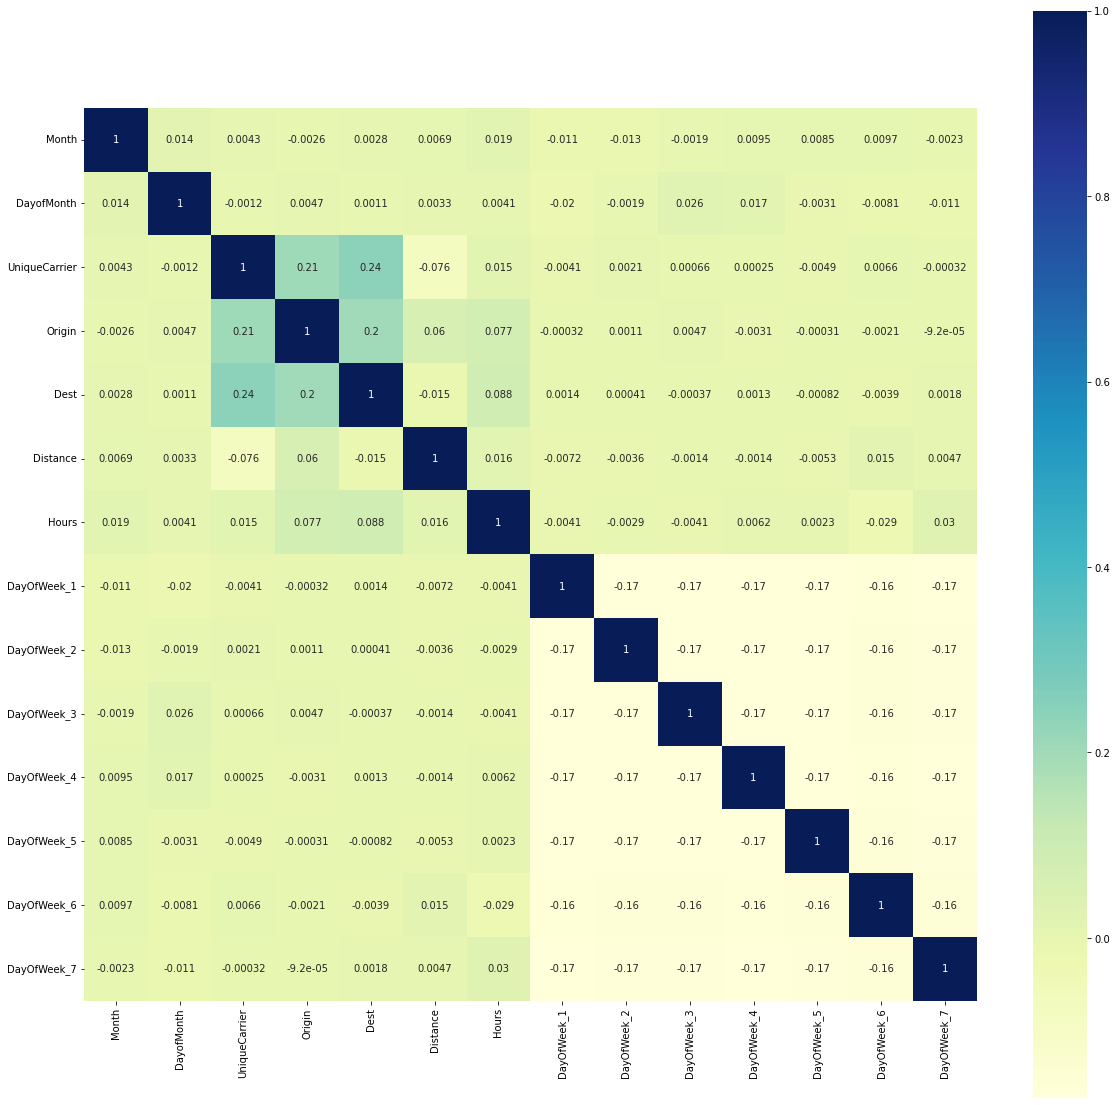

In [36]:
corrmat=X_train_ce.corr()
fig = plt.figure(figsize = (20, 20))
sns.heatmap(corrmat, vmax = 1, square = True, cmap = "YlGnBu", annot = True)
plt.show()

As expected some of the airport and carrier related information are somewhat corelated.

# Model Building 
## Case1: proceed without balancing the data by using PR AUC as the evaluation metric

Since we are dealing with an imbalanced classification problem, we can take area under the precision recall curve as our metric. 
Also, we should use Stratified K-Fold for cross validation

In [63]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import make_scorer
from sklearn.dummy import DummyClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance
from sklearn.metrics import precision_score,recall_score,f1_score,mean_squared_error

We should scale the data before feeding it into our model for better results.

In [99]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range = (0,1))
scaler.fit(X_train_ce)
X_train_ce = scaler.transform(X_train_ce)
X_test_ce = scaler.transform(X_test_ce)

In [61]:
# calculate precision-recall area under curve
def pr_auc(y_true, probas_pred):
    # calculate precision-recall curve
    p, r, _ = precision_recall_curve(y_true, probas_pred)
    # calculate area under curve
    return auc(r, p)
 
# evaluate a model
def evaluate_model(X, y, model):
    # define evaluation procedure
    cv = StratifiedKFold(n_splits=5)
    # define the model evaluation the metric
    metric = make_scorer(pr_auc, needs_proba=True)
    # evaluate model
    scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
    return scores

### Baseline Model
If we always predict the positive class. 

In [101]:
# define the baseline model
model = DummyClassifier(strategy='constant', constant=1)
# evaluate the model
scores = evaluate_model(X_test_ce, y_test, model)
# summarize performance
print('Mean PR AUC: %.3f (%.3f)' % (np.mean(scores),np.std(scores)))

Mean PR AUC: 0.595 (0.000)


In [102]:
def summarize_results(grid_result):
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))

In [103]:
cv = StratifiedKFold(n_splits=5)
scoring = make_scorer(pr_auc, needs_proba=True)

## Logistic Regression

In [104]:
log_reg=LogisticRegression()
grid={'C':10.0 **np.arange(-2,3),'penalty':['l1','l2'],"solver":['liblinear']}
grid_search_lr = GridSearchCV(estimator=log_reg, param_grid=grid, n_jobs=-1, cv=cv, scoring=scoring)
grid_result_lr = grid_search_lr.fit(X_train_ce, y_train)

In [105]:
summarize_results(grid_result_lr)

Best: 0.375543 using {'C': 100.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.353055 (0.006102) with: {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}
0.363787 (0.007003) with: {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
0.374859 (0.008071) with: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
0.374460 (0.007744) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.375476 (0.008214) with: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
0.375465 (0.008166) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.375531 (0.008231) with: {'C': 10.0, 'penalty': 'l1', 'solver': 'liblinear'}
0.375536 (0.008229) with: {'C': 10.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.375538 (0.008232) with: {'C': 100.0, 'penalty': 'l1', 'solver': 'liblinear'}
0.375543 (0.008236) with: {'C': 100.0, 'penalty': 'l2', 'solver': 'liblinear'}


In [106]:
y_pred = grid_result_lr.predict(X_test_ce)
# evaluate the model
scores = evaluate_model(X_test_ce, y_test, grid_result_lr)
# summarize performance
print('Mean PR AUC: %.3f (%.3f)' % (np.mean(scores),np.std(scores)))

Mean PR AUC: 0.370 (0.018)


In [107]:
rms = mean_squared_error(y_test, y_pred, squared=False)
print('The root mean squared error is: ',rms)

The root mean squared error is:  0.43452208283587107


In [108]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.82      0.98      0.89     16191
           1       0.53      0.08      0.14      3808

    accuracy                           0.81     19999
   macro avg       0.67      0.53      0.52     19999
weighted avg       0.76      0.81      0.75     19999



## Random Forest Classifier


In [109]:
rf = RandomForestClassifier()
rf.fit(X_train_ce,y_train)
y_pred=rf.predict(X_test_ce)

In [110]:
# evaluate the model on cross validation score using PR AUC 
scores = evaluate_model(X_train_ce, y_train, rf)
# summarize performance
print('Mean PR AUC: %.3f (%.3f)' % (np.mean(scores),np.std(scores)))

Mean PR AUC: 0.393 (0.003)


In [111]:
rms = mean_squared_error(y_test, y_pred, squared=False)
print('The root mean squared error is: ',rms)

The root mean squared error is:  0.42785412579248067


## Naive Bayes

In [112]:
gnb = GaussianNB()
gnb.fit(X_train_ce,y_train)
y_pred=gnb.predict(X_test_ce)

In [113]:
# evaluate the model on cross validation score using PR AUC 
scores = evaluate_model(X_train_ce, y_train, gnb)
# summarize performance
print('Mean PR AUC: %.3f (%.3f)' % (np.mean(scores),np.std(scores)))

Mean PR AUC: 0.368 (0.006)


In [114]:
rms = mean_squared_error(y_test, y_pred, squared=False)
print('The root mean squared error is:  ',rms)

The root mean squared error is:   0.4411459287883368


In [115]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.83      0.96      0.89     16191
           1       0.47      0.16      0.24      3808

    accuracy                           0.81     19999
   macro avg       0.65      0.56      0.56     19999
weighted avg       0.76      0.81      0.76     19999



## Neural Networks
Let's now use a neural network model to solve the problem and see what results we get. We will be using TensorFlow in this instance.

In [37]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout

In [38]:
X_train_ce.shape

(79995, 14)

Since our train set has 14 columns or 14 features, we will take the first layer of 14 units and a hidden layer with 7 units, both with activation function as Rectified Linear Unit or ReLU. Since this is a classification problem, with only one output which can take value 0 or 1, we will take the last layer of 1 unit with sigmoid function as activation.

In [39]:
model = Sequential()

model.add(Dense(units=14,activation='relu'))

model.add(Dense(units=7,activation='relu'))


model.add(Dense(units=1,activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam')

In [45]:
model.fit(x=X_train_ce, 
          y=y_train, 
          epochs=600,
          validation_data=(X_test_ce, y_test), verbose=1
          )

Epoch 1/600
2500/2500 [==============================] - 3s 1ms/step - loss: 0.4407 - val_loss: 0.4385
Epoch 2/600
2500/2500 [==============================] - 3s 1ms/step - loss: 0.4401 - val_loss: 0.4389
Epoch 3/600
2500/2500 [==============================] - 3s 1ms/step - loss: 0.4403 - val_loss: 0.4402
Epoch 4/600
2500/2500 [==============================] - 3s 1ms/step - loss: 0.4410 - val_loss: 0.4400
Epoch 5/600
2500/2500 [==============================] - 4s 1ms/step - loss: 0.4405 - val_loss: 0.4462
Epoch 6/600
2500/2500 [==============================] - 3s 1ms/step - loss: 0.4409 - val_loss: 0.4385
Epoch 7/600
2500/2500 [==============================] - 3s 1ms/step - loss: 0.4405 - val_loss: 0.4383
Epoch 8/600
2500/2500 [==============================] - 3s 1ms/step - loss: 0.4403 - val_loss: 0.4413
Epoch 9/600
2500/2500 [==============================] - 4s 1ms/step - loss: 0.4407 - val_loss: 0.4413
Epoch 10/600
2500/2500 [==============================] - 5s 2ms/step - l

Epoch 80/600
2500/2500 [==============================] - 3s 1ms/step - loss: 0.4395 - val_loss: 0.4379
Epoch 81/600
2500/2500 [==============================] - 3s 1ms/step - loss: 0.4394 - val_loss: 0.4431
Epoch 82/600
2500/2500 [==============================] - 3s 1ms/step - loss: 0.4398 - val_loss: 0.4394
Epoch 83/600
2500/2500 [==============================] - 3s 1ms/step - loss: 0.4390 - val_loss: 0.4381
Epoch 84/600
2500/2500 [==============================] - 3s 1ms/step - loss: 0.4394 - val_loss: 0.4476
Epoch 85/600
2500/2500 [==============================] - 3s 1ms/step - loss: 0.4397 - val_loss: 0.4430
Epoch 86/600
2500/2500 [==============================] - 3s 1ms/step - loss: 0.4397 - val_loss: 0.4379
Epoch 87/600
2500/2500 [==============================] - 3s 1ms/step - loss: 0.4396 - val_loss: 0.4472
Epoch 88/600
2500/2500 [==============================] - 3s 1ms/step - loss: 0.4392 - val_loss: 0.4477
Epoch 89/600
2500/2500 [==============================] - 3s 1ms

2500/2500 [==============================] - 3s 1ms/step - loss: 0.4388 - val_loss: 0.4640
Epoch 237/600
2500/2500 [==============================] - 4s 1ms/step - loss: 0.4384 - val_loss: 0.4416
Epoch 238/600
2500/2500 [==============================] - 4s 1ms/step - loss: 0.4390 - val_loss: 0.4397
Epoch 239/600
2500/2500 [==============================] - 3s 1ms/step - loss: 0.4383 - val_loss: 0.4381
Epoch 240/600
2500/2500 [==============================] - 3s 1ms/step - loss: 0.4385 - val_loss: 0.4495
Epoch 241/600
2500/2500 [==============================] - 3s 1ms/step - loss: 0.4389 - val_loss: 0.4385
Epoch 242/600
2500/2500 [==============================] - 3s 1ms/step - loss: 0.4385 - val_loss: 0.4376
Epoch 243/600
2500/2500 [==============================] - 4s 1ms/step - loss: 0.4387 - val_loss: 0.4381
Epoch 244/600
2500/2500 [==============================] - 3s 1ms/step - loss: 0.4388 - val_loss: 0.4371
Epoch 245/600
2500/2500 [==============================] - 3s 1ms/ste

2500/2500 [==============================] - 4s 2ms/step - loss: 0.4383 - val_loss: 0.4374
Epoch 393/600
2500/2500 [==============================] - 3s 1ms/step - loss: 0.4380 - val_loss: 0.4423
Epoch 394/600
2500/2500 [==============================] - 3s 1ms/step - loss: 0.4386 - val_loss: 0.4390
Epoch 395/600
2500/2500 [==============================] - 3s 1ms/step - loss: 0.4382 - val_loss: 0.4384
Epoch 396/600
2500/2500 [==============================] - 3s 1ms/step - loss: 0.4380 - val_loss: 0.4473
Epoch 397/600
2500/2500 [==============================] - 3s 1ms/step - loss: 0.4377 - val_loss: 0.4387
Epoch 398/600
2500/2500 [==============================] - 3s 1ms/step - loss: 0.4379 - val_loss: 0.4392
Epoch 399/600
2500/2500 [==============================] - 3s 1ms/step - loss: 0.4381 - val_loss: 0.4414
Epoch 400/600
2500/2500 [==============================] - 3s 1ms/step - loss: 0.4378 - val_loss: 0.4406
Epoch 401/600
2500/2500 [==============================] - 3s 1ms/ste

2500/2500 [==============================] - 3s 1ms/step - loss: 0.4378 - val_loss: 0.4378
Epoch 549/600
2500/2500 [==============================] - 3s 1ms/step - loss: 0.4376 - val_loss: 0.4614
Epoch 550/600
2500/2500 [==============================] - 3s 1ms/step - loss: 0.4377 - val_loss: 0.4385
Epoch 551/600
2500/2500 [==============================] - 3s 1ms/step - loss: 0.4373 - val_loss: 0.4418
Epoch 552/600
2500/2500 [==============================] - 3s 1ms/step - loss: 0.4379 - val_loss: 0.4371
Epoch 553/600
2500/2500 [==============================] - 3s 1ms/step - loss: 0.4374 - val_loss: 0.4366
Epoch 554/600
2500/2500 [==============================] - 3s 1ms/step - loss: 0.4377 - val_loss: 0.4378
Epoch 555/600
2500/2500 [==============================] - 3s 1ms/step - loss: 0.4378 - val_loss: 0.4374
Epoch 556/600
2500/2500 [==============================] - 3s 1ms/step - loss: 0.4376 - val_loss: 0.4416
Epoch 557/600
2500/2500 [==============================] - 3s 1ms/ste

In [46]:
#model.history.history

In [47]:
model_loss = pd.DataFrame(model.history.history)
model_loss.head()

,loss,val_loss
0,0.440706,0.438525
1,0.440116,0.438926
2,0.440325,0.440220
3,0.441031,0.439963
4,0.440520,0.446185


<AxesSubplot:>

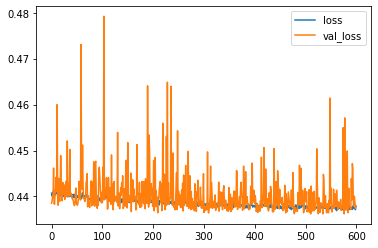

In [48]:
model_loss.plot()

The above plot shows that there is not really an advantage for keeping the epochs large in this model. Let's use early stopping to track the val_loss and stop training once it begins increasing too much!

In [49]:
model = Sequential()
model.add(Dense(units=14,activation='relu'))
model.add(Dense(units=7,activation='relu'))
model.add(Dense(units=1,activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam')

In [50]:
from tensorflow.keras.callbacks import EarlyStopping

In [51]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)

In [52]:
model.fit(x=X_train_ce, 
          y=y_train, 
          epochs=200,
          validation_data=(X_test_ce, y_test), verbose=1,
          callbacks=[early_stop]
          )

Epoch 1/200
2500/2500 [==============================] - 4s 2ms/step - loss: 0.5235 - val_loss: 0.4961
Epoch 2/200
2500/2500 [==============================] - 4s 1ms/step - loss: 0.4999 - val_loss: 0.5060
Epoch 3/200
2500/2500 [==============================] - 3s 1ms/step - loss: 0.4921 - val_loss: 0.4742
Epoch 4/200
2500/2500 [==============================] - 3s 1ms/step - loss: 0.4871 - val_loss: 0.4791
Epoch 5/200
2500/2500 [==============================] - 3s 1ms/step - loss: 0.4852 - val_loss: 0.4668
Epoch 6/200
2500/2500 [==============================] - 3s 1ms/step - loss: 0.4801 - val_loss: 0.4705
Epoch 7/200
2500/2500 [==============================] - 3s 1ms/step - loss: 0.4763 - val_loss: 0.4833
Epoch 8/200
2500/2500 [==============================] - 3s 1ms/step - loss: 0.4742 - val_loss: 0.4625
Epoch 9/200
2500/2500 [==============================] - 3s 1ms/step - loss: 0.4721 - val_loss: 0.4558
Epoch 10/200
2500/2500 [==============================] - 3s 1ms/step - l

Epoch 80/200
2500/2500 [==============================] - 3s 1ms/step - loss: 0.4460 - val_loss: 0.4421
Epoch 81/200
2500/2500 [==============================] - 3s 1ms/step - loss: 0.4448 - val_loss: 0.4449
Epoch 82/200
2500/2500 [==============================] - 3s 1ms/step - loss: 0.4454 - val_loss: 0.4437
Epoch 83/200
2500/2500 [==============================] - 3s 1ms/step - loss: 0.4453 - val_loss: 0.4424
Epoch 84/200
2500/2500 [==============================] - 3s 1ms/step - loss: 0.4448 - val_loss: 0.4477
Epoch 85/200
2500/2500 [==============================] - 3s 1ms/step - loss: 0.4447 - val_loss: 0.4443
Epoch 86/200
2500/2500 [==============================] - 3s 1ms/step - loss: 0.4445 - val_loss: 0.4473
Epoch 87/200
2500/2500 [==============================] - 3s 1ms/step - loss: 0.4441 - val_loss: 0.4420
Epoch 88/200
2500/2500 [==============================] - 3s 1ms/step - loss: 0.4443 - val_loss: 0.4405
Epoch 89/200
2500/2500 [==============================] - 3s 1ms

<AxesSubplot:>

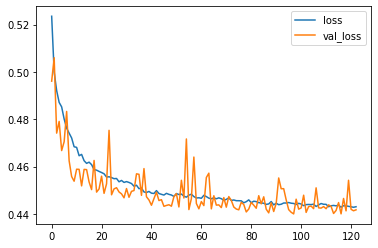

In [53]:
model_loss = pd.DataFrame(model.history.history)
model_loss.plot()

We can see that we stopped out early using early stopping as our model didn't train for a full 600 epochs. Let's also try adding in dropout layers.

In [54]:
from tensorflow.keras.layers import Dropout

In [55]:
model_dp = Sequential()
model_dp.add(Dense(units=14,activation='relu'))
model_dp.add(Dropout(0.5))

model_dp.add(Dense(units=7,activation='relu'))
model_dp.add(Dropout(0.5))

model_dp.add(Dense(units=1,activation='sigmoid'))
model_dp.compile(loss='binary_crossentropy', optimizer='adam')

In [56]:
model_dp.fit(x=X_train_ce, 
          y=y_train, 
          epochs=200,
          validation_data=(X_test_ce, y_test), verbose=1,
          callbacks=[early_stop]
          )

Epoch 1/200
2500/2500 [==============================] - 3s 1ms/step - loss: 5.9503 - val_loss: 0.4883
Epoch 2/200
2500/2500 [==============================] - 3s 1ms/step - loss: 0.5133 - val_loss: 0.4869
Epoch 3/200
2500/2500 [==============================] - 3s 1ms/step - loss: 0.4875 - val_loss: 0.4868
Epoch 4/200
2500/2500 [==============================] - 3s 1ms/step - loss: 0.4872 - val_loss: 0.4868
Epoch 5/200
2500/2500 [==============================] - 3s 1ms/step - loss: 0.4869 - val_loss: 0.4868
Epoch 6/200
2500/2500 [==============================] - 3s 1ms/step - loss: 0.4868 - val_loss: 0.4868
Epoch 7/200
2500/2500 [==============================] - 3s 1ms/step - loss: 0.4868 - val_loss: 0.4869
Epoch 8/200
2500/2500 [==============================] - 3s 1ms/step - loss: 0.4868 - val_loss: 0.4868
Epoch 9/200
2500/2500 [==============================] - 3s 1ms/step - loss: 0.4868 - val_loss: 0.4868
Epoch 10/200
2500/2500 [==============================] - 3s 1ms/step - l

<AxesSubplot:>

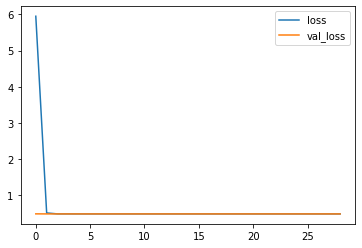

In [57]:
model_loss = pd.DataFrame(model_dp.history.history)
model_loss.plot()

In [65]:
predictions=(model.predict(X_test_ce) > 0.5).astype("int32")

625/625 [==============================] - 0s 660us/step


## Model Evaluation


In [66]:
rms = mean_squared_error(y_test, predictions, squared=False)
print('The root mean squared error is: ',rms)

The root mean squared error is:  0.4330812602374968


In [67]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.82      0.99      0.90     16191
           1       0.61      0.04      0.08      3808

    accuracy                           0.81     19999
   macro avg       0.71      0.52      0.49     19999
weighted avg       0.78      0.81      0.74     19999



# Final Comments
We see that the random forest classifier is giving us the best results, although all four models are performing roughly the same. Obviously there is a lot more that we still could've done with this project, like hyperparameter tuning, trying different classifiers and maybe more feature engineering.